## Pytorch + Ray Train Distributed Training
This cell imports all the necessary libraries and modules used throughout the notebook:

- **Standard library**: Utilities for file paths, temporary directories, unique IDs, and file locking.
- **Third-party libraries**: 
  - `filelock` for safe concurrent file access.
  - `PIL.Image` for image processing.
  - `matplotlib.pyplot` for data visualization.
  - `torch`, `torch.nn`, `torch.utils.data`, and `torchmetrics` for building, training, and evaluating PyTorch models.
- **torchvision**: 
  - Datasets (CIFAR-10), pretrained models (ResNet-18), and common data transforms for image preprocessing.
- **Ray**: 
  - Distributed training utilities including `TorchTrainer` for scalable training, and configuration classes for managing Ray training jobs.

In [1]:
# Standard library
import os
import tempfile
import uuid
from pathlib import Path

# Third-party libraries
from filelock import FileLock
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchmetrics.classification import Accuracy

# torchvision (separate for clarity)
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms

# Ray imports
import ray
from ray.train.torch import TorchTrainer
from ray.train import ScalingConfig, RunConfig, CheckpointConfig

### Loading and Inspecting the CIFAR-10 Test Dataset

This cell downloads the CIFAR-10 test set and examines a single sample.

- `CIFAR10(root=..., download=True, train=False)`: Downloads (if needed) and loads the test split of CIFAR-10. Each sample is a tuple: `(PIL image, label)`.
- `next(iter(data))`: Retrieves the first image-label pair from the dataset.
- `plt.imshow(next(iter(data))[0])`: Displays the image from the first sample using matplotlib.

In [2]:
data = CIFAR10(root="../marimo_notebooks/data",download=True,train=False)
data

100%|██████████| 170M/170M [00:01<00:00, 103MB/s]  


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../marimo_notebooks/data
    Split: Test

In [3]:
# the data contains of a PIL image and the label
next(iter(data))

(<PIL.Image.Image image mode=RGB size=32x32>, 3)

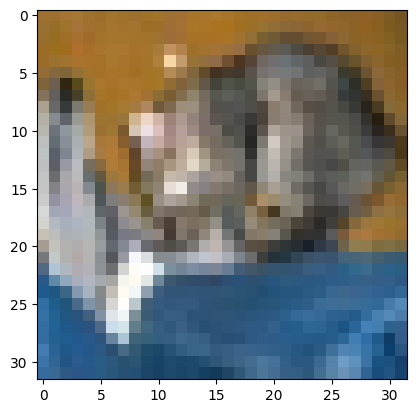

In [4]:
plt.imshow(next(iter(data))[0])

In [5]:
class_to_idx = data.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

### Loading a Pretrained ResNet-18 Model

This cell demonstrates how to load the pretrained ResNet-18 model from torchvision:

- `ResNet18_Weights.IMAGENET1K_V1`: Specifies the standard pretrained weights trained on ImageNet.
- `resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)`: Loads a ResNet-18 model instance with the pretrained weights applied.

Printing `model` displays the architecture.

In [6]:
weights = ResNet18_Weights.IMAGENET1K_V1

In [7]:
model = resnet18(weights=ResNet18_Weights)
model

/home/ray/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ray/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 212MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Defining the CIFAR-10 DataLoader with Preprocessing

This function prepares PyTorch DataLoaders for the CIFAR-10 dataset, using the same image transforms as those expected by a pretrained ResNet-18 model:

- Retrieves the ResNet-18 ImageNet normalisation and resizing transforms with `weights.transforms()`.
- Downloads the CIFAR-10 training and test sets (if not already present), applying the ResNet-18 transforms to each image.
- Optionally, subsets the data to the first 1,000 samples for quicker experimentation.
- Wraps the datasets with PyTorch `DataLoader` objects to enable mini-batch loading and shuffling during training and evaluation.

Returns:  
`train_dataloader`, `valid_dataloader` — ready-to-use for model training and validation.

In [8]:
def get_cifar_dataloader(batch_size):
    weights = ResNet18_Weights.IMAGENET1K_V1
    resnet18_transforms = weights.transforms()
    with FileLock(os.path.expanduser("~/cifar_data.lock")):
        train = CIFAR10(
            root="~/cifar_data",
            train=True,
            download=True,
            transform=resnet18_transforms,
        )
        valid = CIFAR10(
            root="~/cifar_data",
            train=False,
            download=True,
            transform=resnet18_transforms,
        )
    train_sub = Subset(train,indices=range(1000))
    valid_sub = Subset(valid,indices=range(1000))
    # dataloaders to get data in batches
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid, batch_size=batch_size)

    return train_dataloader, valid_dataloader



In [9]:
sample_dataloader = next(iter(get_cifar_dataloader(3)))
single_batch =  next(iter(sample_dataloader))

100%|██████████| 170M/170M [00:01<00:00, 102MB/s]  


In [10]:
single_batch[1].shape

torch.Size([3])

In [11]:
single_batch[0].shape

torch.Size([3, 3, 224, 224])

### Ray Distributed Training Function for Transfer Learning on CIFAR-10

This function implements the distributed training loop for fine-tuning a ResNet-18 model on the CIFAR-10 dataset using Ray Train. The workflow includes:

- **Configuration**: Reads training hyperparameters (epochs, batch size, learning rate, weight decay, and number of classes) from `config`.
- **Device Setup**: Automatically selects GPU (`cuda`), or CPU.
- **Model Preparation**:
  - Loads a ResNet-18 model pre-trained on ImageNet.
  - Freezes all layers except the final fully-connected (`fc`) layer, which is replaced to match the number of CIFAR-10 classes.
  - Wraps the model for distributed training with Ray.
- **Optimizer and Loss**: Uses AdamW for optimization and cross-entropy as the loss function.
- **Data Loading**:
  - Prepares training and validation DataLoaders with transforms compatible with ResNet-18.
  - Ensures data is properly sharded for distributed execution.
- **Training Loop**:
  - Trains for the specified number of epochs, accumulating average loss and accuracy for both training and validation sets.
  - Evaluates on the validation set after each epoch (inference mode, no gradients).
- **Metrics and Checkpointing**:
  - Reports epoch-level training and validation metrics (loss, accuracy) to Ray for centralized tracking.
  - Saves a model checkpoint at each epoch for potential recovery or analysis.
  - Prints metrics from the main worker for logging and monitoring.

In [12]:
def train_func(config):

    epochs = config["epochs"]
    batch_size = config["batch_size"]
    lr = config["lr"]
    
    
    # use detected device
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

    # metrics
    accuracy = Accuracy(task="multiclass", num_classes=config["num_classes"]).to(device)
    
    weights = ResNet18_Weights.IMAGENET1K_V1


    # freezing the all weights except the last one
    model = resnet18(weights=weights)
    for parameter in model.parameters():
        parameter.requires_grad = False

    # outputs 10 classes
    model.fc = nn.Linear(512,config["num_classes"],bias=True)
    # prepare model
    model = ray.train.torch.prepare_model(model)
 
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

    train_dataloader, valid_dataloader = get_cifar_dataloader(batch_size=batch_size)
    train_dataloader = ray.train.torch.prepare_data_loader(train_dataloader)
    valid_dataloader = ray.train.torch.prepare_data_loader(valid_dataloader)

    for epoch in range(epochs):
        # checking if training is scheduled in a distributed setting or not.
        if ray.train.get_context().get_world_size() > 1:
            train_dataloader.sampler.set_epoch(epoch)
        train_loss = 0.0
        train_acc = 0.0
        model.train()
        for idx, batch in enumerate(train_dataloader):
            x, y = batch[0], batch[1]
            y_preds = model(x)
            y_labels = y_preds.argmax(dim=1)
            loss = loss_fn(y_preds,y)
            acc = accuracy(y_labels,y)
            train_loss +=  loss.item()
            train_acc += acc.item()
        train_loss /=len(train_dataloader)
        train_acc /=len(train_dataloader)

        valid_loss = 0.0
        valid_acc = 0.0
        model.eval()
        with torch.inference_mode():
            for idx, batch in enumerate(valid_dataloader):
                x, y = batch[0], batch[1]
                y_preds = model(x)
                y_labels = y_preds.argmax(dim=1)
                loss = loss_fn(y_preds,y)
                acc = accuracy(y_labels,y)
                valid_loss +=  loss.item()
                valid_acc += acc.item()
                valid_loss /=len(valid_dataloader)
                valid_acc /=len(valid_dataloader)
        
        metrics = {"epoch":epoch,"train_loss":train_loss, "train_acc":train_acc,
                  "valid_loss":valid_loss, "valid_acc":valid_acc}

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            torch.save(
                model.module.state_dict(),
                os.path.join(temp_checkpoint_dir, "model.pt")
            )
            ray.train.report(
                metrics,
                checkpoint=ray.train.Checkpoint.from_directory(temp_checkpoint_dir),
            )

        if ray.train.get_context().get_world_rank() == 0:
            print(metrics)

### Configuring Ray TorchTrainer for Distributed Training

This section sets up the Ray TorchTrainer to launch distributed training with the following components:

- **Global Training Parameters**: 
  - Defines the overall batch size, number of parallel workers, and whether to use GPUs.
  - Calculates per-worker batch size.

- **Training Configuration (`train_config`)**:
  - Specifies learning rate, number of epochs, number of classes, per-worker batch size, and weight decay for the optimizer.

- **Scaling Configuration (`scaling_config`)**:
  - Sets the number of workers and whether to use GPUs for distributed training.

- **Run Configuration (`run_config`)**:
  - Specifies the experiment's storage location for checkpoints and logs.
  - Assigns a unique run name for tracking.
  - Configures checkpointing behavior (e.g., how many to keep, checkpoint selection criteria).

- **Trainer Instantiation**:
  - Creates a `TorchTrainer` object with all the above configs, ready to launch the training loop (`train_func`) in parallel across the specified workers.

In [13]:
global_batch_size = 100
num_workers = 2
use_gpu = True

train_config = {
    "lr": 0.01,
    "epochs": 3,
    "num_classes": 10,
    "batch_size": global_batch_size // num_workers,
    "weight_decay": 0.02
}
scaling_config = ScalingConfig(num_workers=num_workers, use_gpu=use_gpu)
run_config = RunConfig(
    #storage_path=str(Path("../marimo_notebooks/data/storage_path").resolve()), # local_testing
    storage_path="/mnt/cluster_storage", # we could use s3 as well
    name=f"ray_train_torch_run-{uuid.uuid4().hex}",
    checkpoint_config = CheckpointConfig(num_to_keep=1,
    checkpoint_score_attribute="train_acc",
    checkpoint_score_order="max",) 
)

trainer = TorchTrainer(
    train_loop_per_worker=train_func,
    train_loop_config=train_config,
    scaling_config=scaling_config,
    run_config=run_config,
)

2025-08-03 12:05:11,436	INFO worker.py:1747 -- Connecting to existing Ray cluster at address: 100.106.5.102:6379...
2025-08-03 12:05:11,447	INFO worker.py:1918 -- Connected to Ray cluster. View the dashboard at https://session-xsclvf1y3h8ri22vxrxzy7b516.i.anyscaleuserdata.com 
2025-08-03 12:05:11,456	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_8b63b426ff3536854f76f787bd3e43ad41f5a0ed.zip' (3.67MiB) to Ray cluster...
2025-08-03 12:05:11,472	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_8b63b426ff3536854f76f787bd3e43ad41f5a0ed.zip'.


In [14]:
# fitting the model
result = trainer.fit()
print(f"Training result: {result}")

2025-08-03 12:05:13,639	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2025-08-03 12:05:14 (running for 00:00:00.11)
Using FIFO scheduling algorithm.
Logical resource usage: 0/8 CPUs, 0/1 GPUs (0.0/1.0 anyscale/node-group:head, 0.0/2.0 anyscale/provider:aws, 0.0/2.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/accelerator_shape:1xT4, 0.0/1.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/1.0 accelerator_type:T4)
Result logdir: /tmp/ray/session_2025-08-03_11-51-23_287332_2477/artifacts/2025-08-03_12-05-13/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/driver_artifacts
Number of trials: 1/1 (1 PENDING)


(autoscaler +29s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +29s) [autoscaler] [1xT4:8CPU-32GB] Attempting to add 1 node to the cluster (increasing from 1 to 2).
== Status ==
Current time: 2025-08-03 12:05:19 (running for 00:00:05.13)
Using FIFO scheduling algorithm.
Logical resource usage: 0/8 CPUs, 0/1 GPUs (0.0/1.0 anys

(RayTrainWorker pid=11438, ip=100.118.46.34) Setting up process group for: env:// [rank=0, world_size=2]
(TorchTrainer pid=11366, ip=100.118.46.34) Started distributed worker processes: 
(TorchTrainer pid=11366, ip=100.118.46.34) - (node_id=f67d0524a4d5d05bfc9bd197ae5d9be2a3a7cb98ad05de081a32a24d, ip=100.118.46.34, pid=11438) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=11366, ip=100.118.46.34) - (node_id=344ab1fc9d7bd523909d38e144cc12a9c836d82cd5cb11115590aad5, ip=100.121.10.56, pid=3033) world_rank=1, local_rank=0, node_rank=1


== Status ==
Current time: 2025-08-03 12:07:49 (running for 00:02:35.76)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 anyscale/accelerator_shape:1xT4, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2025-08-03_11-51-23_287332_2477/artifacts/2025-08-03_12-05-13/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


(RayTrainWorker pid=11438, ip=100.118.46.34) Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ray/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]46.34) 
 49%|████▉     | 21.9M/44.7M [00:00<00:00, 229MB/s]0m 
(RayTrainWorker pid=3033, ip=100.121.10.56) Moving model to device: cuda:0
(RayTrainWorker pid=3033, ip=100.121.10.56) Wrapping provided model in DistributedDataParallel.
100%|██████████| 44.7M/44.7M [00:00<00:00, 230MB/s]0m 
 21%|██        | 35.9M/170M [00:00<00:02, 53.6MB/s]0m 


== Status ==
Current time: 2025-08-03 12:07:54 (running for 00:02:40.78)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/2.0 anyscale/accelerator_shape:1xT4, 0.0/3.0 anyscale/region:us-east-2, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2025-08-03_11-51-23_287332_2477/artifacts/2025-08-03_12-05-13/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




 92%|█████████▏| 157M/170M [00:02<00:00, 56.3MB/s] 
 94%|█████████▍| 160M/170M [00:02<00:00, 56.3MB/s]0m 
 95%|█████████▌| 163M/170M [00:03<00:00, 56.4MB/s] 
 97%|█████████▋| 166M/170M [00:03<00:00, 56.4MB/s]0m 
100%|██████████| 170M/170M [00:03<00:00, 54.2MB/s] 
100%|██████████| 170M/170M [00:03<00:00, 54.8MB/s]0m 


== Status ==
Current time: 2025-08-03 12:07:59 (running for 00:02:45.80)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/2.0 anyscale/accelerator_shape:1xT4, 0.0/3.0 anyscale/region:us-east-2, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2025-08-03_11-51-23_287332_2477/artifacts/2025-08-03_12-05-13/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-08-03 12:08:04 (running for 00:02:50.82)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/3.0 anyscale/region:us-east-2, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/accelerator_shape:1xT4, 0.0/2.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true

(RayTrainWorker pid=11438, ip=100.118.46.34) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/TorchTrainer_1c8c1_00000_0_2025-08-03_12-05-13/checkpoint_000000)
  0%|          | 0.00/170M [00:00<?, ?B/s] [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
 91%|█████████ | 154M/170M [00:02<00:00, 56.0MB/s] [repeated 55x across cluster]
(RayTrainWorker pid=11438, ip=100.118.46.34) Moving model to device: cuda:0
(RayTrainWorker pid=11438, ip=100.118.46.34) Wrapping provided model in DistributedDataParallel.


(RayTrainWorker pid=11438, ip=100.118.46.34) {'epoch': 0, 'train_loss': 2.5237470211982727, 'train_acc': 0.07551999923586845, 'valid_loss': 0.026172352739970938, 'valid_acc': 0.0002040404015397456}
(RayTrainWorker pid=3033, ip=100.121.10.56) Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ray/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
== Status ==
Current time: 2025-08-03 12:09:30 (running for 00:04:16.11)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/accelerator_shape:1xT4, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/3.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/node-group:head)
Result logdir: /tmp/ray/session_2025-08-03_11-51-23_287332_2477/artifacts/2025-08-03_12-05-13/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=3033, ip=100.121.10.56) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/TorchTrainer_1c8c1_00000_0_2025-08-03_12-05-13/checkpoint_000000)


== Status ==
Current time: 2025-08-03 12:09:35 (running for 00:04:21.15)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/2.0 anyscale/accelerator_shape:1xT4, 0.0/3.0 anyscale/region:us-east-2, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/node-group:head)
Result logdir: /tmp/ray/session_2025-08-03_11-51-23_287332_2477/artifacts/2025-08-03_12-05-13/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-08-03 12:09:40 (running for 00:04:26.17)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/2.0 anyscale/accelerator_shape:1xT4, 0.0/3.0 anyscale/region:us-east-2, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/node-group:head

(RayTrainWorker pid=11438, ip=100.118.46.34) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/TorchTrainer_1c8c1_00000_0_2025-08-03_12-05-13/checkpoint_000001)


(RayTrainWorker pid=11438, ip=100.118.46.34) {'epoch': 1, 'train_loss': 2.524965055465698, 'train_acc': 0.07599999927729369, 'valid_loss': 0.02618222676745298, 'valid_acc': 0.0004020403971141007}
== Status ==
Current time: 2025-08-03 12:11:05 (running for 00:05:51.47)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/2.0 accelerator_type:T4, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 anyscale/accelerator_shape:1xT4, 0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/node-group:head)
Result logdir: /tmp/ray/session_2025-08-03_11-51-23_287332_2477/artifacts/2025-08-03_12-05-13/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=3033, ip=100.121.10.56) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/TorchTrainer_1c8c1_00000_0_2025-08-03_12-05-13/checkpoint_000001)


== Status ==
Current time: 2025-08-03 12:11:10 (running for 00:05:56.57)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/2.0 accelerator_type:T4, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 anyscale/accelerator_shape:1xT4, 0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/node-group:head)
Result logdir: /tmp/ray/session_2025-08-03_11-51-23_287332_2477/artifacts/2025-08-03_12-05-13/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-08-03 12:11:15 (running for 00:06:01.59)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/2.0 anyscale/accelerator_shape:1xT4, 0.0/2.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 accelerator_type:T4, 0.0/3.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/node-group:head

(RayTrainWorker pid=11438, ip=100.118.46.34) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/TorchTrainer_1c8c1_00000_0_2025-08-03_12-05-13/checkpoint_000002)


(RayTrainWorker pid=11438, ip=100.118.46.34) {'epoch': 2, 'train_loss': 2.5232997498512266, 'train_acc': 0.07731999935209752, 'valid_loss': 0.026231056780898935, 'valid_acc': 0.00040404039706939726}
== Status ==
Current time: 2025-08-03 12:12:40 (running for 00:07:26.88)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/3.0 anyscale/provider:aws, 0.0/2.0 anyscale/accelerator_shape:1xT4, 0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/2.0 accelerator_type:T4, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2025-08-03_11-51-23_287332_2477/artifacts/2025-08-03_12-05-13/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=3033, ip=100.121.10.56) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/TorchTrainer_1c8c1_00000_0_2025-08-03_12-05-13/checkpoint_000002)
2025-08-03 12:12:45,440	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/cluster_storage/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a' in 0.2057s.
2025-08-03 12:12:45,443	INFO tune.py:1041 -- Total run time: 451.80 seconds (451.26 seconds for the tuning loop).


== Status ==
Current time: 2025-08-03 12:12:45 (running for 00:07:31.47)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/16 CPUs, 2.0/2 GPUs (0.0/3.0 anyscale/provider:aws, 0.0/2.0 anyscale/accelerator_shape:1xT4, 0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 anyscale/node-group:1xT4:8CPU-32GB, 0.0/2.0 accelerator_type:T4, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2025-08-03_11-51-23_287332_2477/artifacts/2025-08-03_12-05-13/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)


Training result: Result(
  metrics={'epoch': 2, 'train_loss': 2.5232997498512266, 'train_acc': 0.07731999935209752, 'valid_loss': 0.026231056780898935, 'valid_acc': 0.00040404039706939726},
  path='/mnt/cluster_storage/ray_train_torch_run-7d3a2281bfd44c5d89ab4dc5ce89593a/TorchTrainer_1c8c1_00000_0_2025-08-03_12-05-13',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/mnt/c

(autoscaler +12m9s) [autoscaler] Downscaling node i-0f146bed1cacc476a (node IP: 100.118.46.34) due to node idle termination.
(autoscaler +12m9s) [autoscaler] Downscaling node i-0a57fbdcb90ed7a2c (node IP: 100.121.10.56) due to node idle termination.


In [ ]:
ray.shutdown()